#  Introduction to atomman: Region selectors

__Lucas M. Hale__, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), _Materials Science and Engineering Division, NIST_.
    
[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 

## 1. Introduction

*Added version 1.3.0*

It can be useful during both system construction and analysis to identify and select atoms within specific regions of space.  The atomman.region submodule allows for geometric regions to be defined and have methods for identifying if the points are above/below or inside/outside the shapes.

__Library imports__

In [1]:
# Standard Python libraries
import datetime

# http://www.numpy.org/
import numpy as np

# https://github.com/usnistgov/atomman
import atomman as am

# https://matplotlib.org/
import matplotlib.pyplot as plt
%matplotlib inline

# Show atomman version
print('atomman version =', am.__version__)

# Show date of Notebook execution
print('Notebook executed on', datetime.date.today())

atomman version = 1.3.2
Notebook executed on 2020-04-15


Define function for plotting projection plots of atoms, with positions given by pos and colors by atype.

In [2]:
def projectionplots(atoms):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,4))

    ax1.scatter(atoms.pos[:,0], atoms.pos[:,1], marker='o', c=atoms.atype)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')

    ax2.scatter(atoms.pos[:,0], atoms.pos[:,2], marker='o', c=atoms.atype)
    ax2.set_xlabel('x')
    ax2.set_ylabel('z')

    ax3.scatter(atoms.pos[:,1], atoms.pos[:,2], marker='o', c=atoms.atype)
    ax3.set_xlabel('y')
    ax3.set_ylabel('z')

In [3]:
def projectionplots(atoms):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,4))

    # Separate by atype
    for atype in atoms.atypes:
        pos = atoms.pos[atoms.atype == atype]
        
        ax1.plot(pos[:,0], pos[:,1], 'o')
        ax2.plot(pos[:,0], pos[:,2], 'o')
        ax3.plot(pos[:,1], pos[:,2], 'o')
    
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_xlim(-40, 40)
    ax1.set_ylim(-40, 40)
    
    ax2.set_xlabel('x')
    ax2.set_ylabel('z')
    ax2.set_xlim(-40, 40)
    ax2.set_ylim(-40, 40)
    
    ax3.set_xlabel('y')
    ax3.set_ylabel('z')
    ax3.set_xlim(-40, 40)
    ax3.set_ylim(-40, 40)

Construct a demonstration fcc system

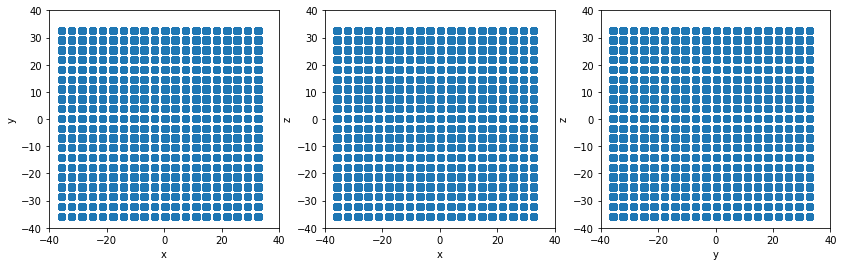

In [4]:
box = am.Box.cubic(a=3.6)
atoms = am.Atoms(pos=[[0.0, 0.0, 0.0], [0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5, 0.0]])
ucell = am.System(box=box, atoms=atoms)
system = ucell.supersize((-10, 10), (-10, 10), (-10, 10))

projectionplots(system.atoms)

## 2. Plane slicing

The atomman.region.Plane class allows for a plane to be defined, which can then be used to slice a system. Making a planar slice consists of two steps: defining a Plane, then using it to identify all atoms above/below it.

### 2.1 Initializing a Plane

A plane can be uniquely defined in space using a normal vector and a single point located anywhere in that plane.

Parameters
        
- **normal** (*array-like object*) 3D normal vector of the plane.

- **point** (*array-like object*) 3D vector coordinate of any point in the plane.

### 2.2 Plane.above() and Plane.below()

Slices can then be made using the plane's above() and below() methods. These are defined to be opposite functions: any atoms not "below" are "above".

Parameters
        
- **pos** (*array-like object*) Nx3 array of coordinates. 

- **inclusive** (*bool, optional*) Indicates if points in the plane are to be included.  Default value is True for below() and False for above().

Returns

- (*numpy.NDArray*) N array of bool values

### 2.3 Examples

Use Plane and System.atoms_ix to remove all atoms with positive y values

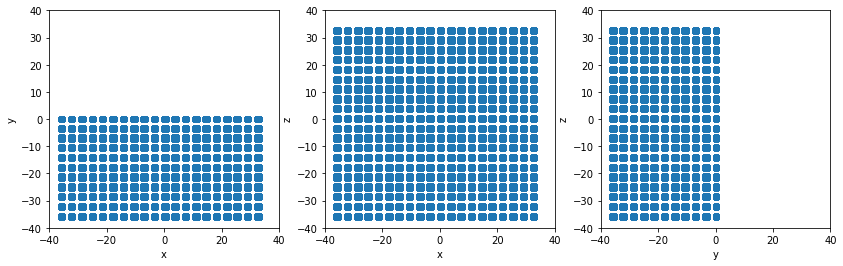

In [5]:
# Define a simple plane normal to the y-axis at the origin
plane = am.region.Plane(normal=[0,1,0], point=[0,0,0])

# Identify all atoms below the plane
isbelow = plane.below(system.atoms.pos)

# Use atoms_ix to build new system with only the below atoms
newsystem = system.atoms_ix[isbelow]

# Make projectionplots
projectionplots(newsystem.atoms)

Due to atomman's design, region selections can also be made on per-atom properties themselves allowing for easily modifying or analyzing the properties of atoms in specific regions.

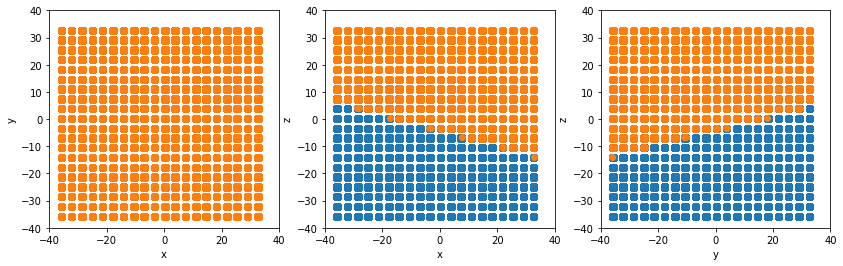

In [6]:
# Define a plane with more complicated normal and position
plane = am.region.Plane(normal=[1.5, -1.4, 5.2], point=[-5.7, 1.2, 7.1])

# Change atypes of all atoms above the plane
system.atoms.atype[plane.above(system.atoms.pos)] = 2

# Make projectionplots
projectionplots(system.atoms)

# Reset all atypes back to 1
system.atoms.atype = 1

## 3. Volume selection

Points inside/outside of volumes can also be selected based on a number of simple geometric shapes.  Each shape is defined as a separate subclass of the template Shape class.

### 3.1 Shape.inside() and Shape.outside()

Indicates if position(s) are inside/outside the shape. These are defined to be opposite functions: any atoms not "inside" are "outside".
        
Parameters
        
- **pos** (*array-like object*) Nx3 array of coordinates. 

- **inclusive** (*bool, optional*) Indicates if points on the shape's boundaries are to be included. Default value is True for inside, False for outside.
        
Returns
        
- (*numpy.NDArray*) N array of bool values.

### 3.2 Box

The atomman.Box class used in defining the regions of atomic systems already provides a comprehensive representation of a generic parallelepiped. As such, the class has been extended to be a child of Shape, complete with inside/outside functions.

Show that all atoms in the system are inside the box, but only a few atoms are inside the original unit cell

In [7]:
print(f'system has {system.natoms} atoms')

# count number of system's atoms inside system's box
numinside = np.sum(system.box.inside(system.atoms.pos))

print(f"{numinside} atoms are inside system's box")

# count number of system's atoms inside ucell's box
numinside = np.sum(ucell.box.inside(system.atoms.pos))

print(f"{numinside} atoms are inside ucell's box")

system has 32000 atoms
32000 atoms are inside system's box
4 atoms are inside ucell's box


### 3.3 Sphere

Spherical selections can be made using the atomman.region.Sphere class.  Spheres are easily defined with just a center point and a radius.

Parameters
        
- **center** (*array-like object*) The position of the sphere's center.

- **radius** (*float*) The sphere's radius. 

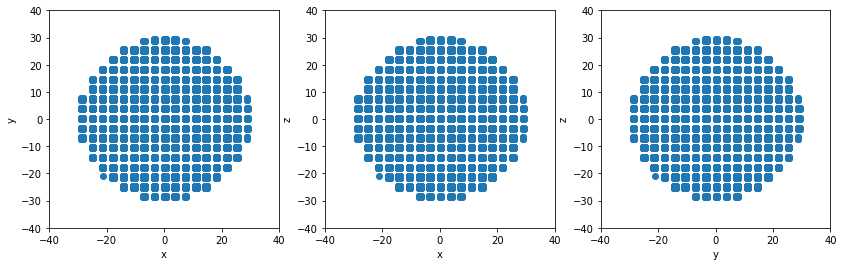

In [8]:
# Define a sphere at the origin with a radius of 30
sphere = am.region.Sphere([0,0,0], 30)

# Slice to create spherical particle system
newsystem = system.atoms_ix[sphere.inside(system.atoms.pos)]

# Make projectionplots
projectionplots(newsystem.atoms)

### 3.4 Cylinder

Cylindrical selections can be made using the atomman.region.Cylinder class.  

Parameters
        
- **center1** (*array-like object*) A point on the cylinder's axis.  If endcaps is True, the point is taken as the center of one of the cylinder's endcap planes.

- **center2** (*array-like object*) A point on the cylinder's axis.  If endcaps is True, the point is taken as the center of one of the cylinder's endcap planes.

- **radius** (*float*) The cylinder's radius.

- **endcaps** (*bool, optional*) Indicates if the cylindrical volume is taken as capped at the two ends. If False, only the radial distances from the axis will be considered. If True, positions are also checked to see if they are above/below the planes defined by the axis and the center points.  Default value is True.

These parameters were selected to provide the most concise representation of a generic cylinder.  Note that the cylinder's axis vector is related to the two center points as 

$$ axis = \frac{center2 - center1}{|center2 - center1|}$$

Create a cylindrical particle using cylinder

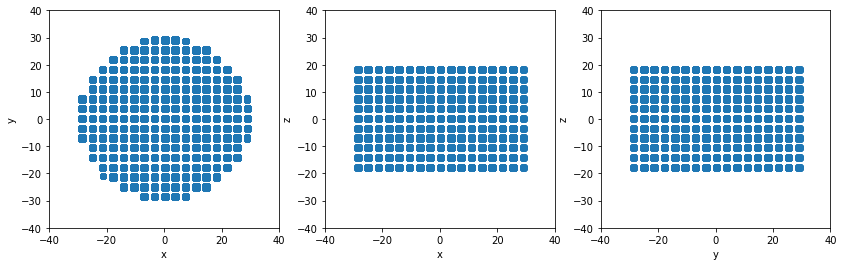

In [9]:
# Define a cylinder with axis along the z axis
center1 = [0, 0, -20]
center2 = [0, 0, 20]
radius = 30
cylinder = am.region.Cylinder(center1, center2, radius)

# Slice to create cylindrical particle system
newsystem = system.atoms_ix[cylinder.inside(system.atoms.pos)]

# Make projectionplots
projectionplots(newsystem.atoms)

Change endcaps to false to ignore plane boundaries and create a nanowire system instead

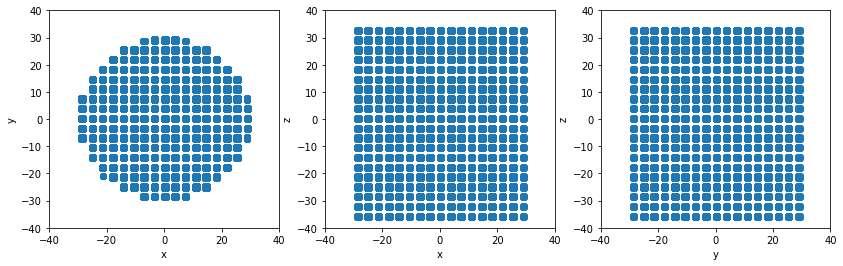

In [10]:
cylinder.endcaps = False

# Slice to create cylindrical particle system
newsystem = system.atoms_ix[cylinder.inside(system.atoms.pos)]

# Make projectionplots
projectionplots(newsystem.atoms)